In [3]:
from spmf import Spmf
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import ast
pd.options.plotting.backend = "plotly"
import plotly.express as px
# from chart_studio import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.subplots as sp

pd.options.display.max_colwidth = None
pd.set_option('display.max_rows', 70)
from pandas.plotting import table 
#import nltk

In [4]:
#import numpy as np 
#from pandas import DataFrame
import seaborn as sns
%matplotlib inline

In [3]:
data=pd.read_csv("sorted_coded_session_293s_merged.csv")

In [ ]:
print("Number of observation after removing apps:",data.shape[0])
print("Number of different apps left:",data.app_code.nunique())

# keep coverage of data

In [4]:
cumulated_time_spend=data.groupby(["user_id","app_code"])\
                    .agg({'time_spend':'sum'})['time_spend']\
                    .groupby('user_id', group_keys=False)\
                    .apply(lambda x: x.sort_values(ascending=False).cumsum()).reset_index()

In [5]:
total_time_spend=data.groupby('user_id').time_spend.sum()

In [6]:
cumulated_time_spend=cumulated_time_spend.join(total_time_spend,on='user_id',rsuffix="_total")

In [7]:
cumulated_time_spend['coverage']=cumulated_time_spend.time_spend/cumulated_time_spend.time_spend_total

In [8]:
cumulated_time_spend=cumulated_time_spend[cumulated_time_spend.coverage.shift(1)<=0.80]

In [9]:
data_coverage=data.merge(cumulated_time_spend,how='inner',on=['user_id','app_code'])

As a sanity check we take a look at how many apps are left for the each user after the apps were removed.

In [10]:
(data_coverage.groupby('user_id').app_code.nunique()==1).sum()

115

In [11]:
data_coverage.groupby('user_id').app_code.nunique()[data_coverage.groupby('user_id').app_code.nunique()<5]

user_id
2       4
3       4
7       4
9       3
11      1
       ..
9980    2
9983    4
9990    3
9992    4
9997    4
Name: app_code, Length: 2319, dtype: int64

In [12]:
print("Number of observation after removing apps:",data_coverage.shape[0])
print("Number of different apps left:",data_coverage.app_code.nunique())

Number of observation after removing apps: 115545907
Number of different apps left: 3489


Initially this results in 11 users only having 1 app left and 3469 users having less than 10 different apps. Therefore the coverage is increased form 90% to 95%. Here 1015 users have less than 10 different apps. for 99% 89 users have less than 10 apps. Only 7 have less than 5 and only one user has three apps, and no user has less than 3 different apps.

## update session length

In [13]:
data_coverage=data_coverage.merge(data_coverage.groupby(['user_id','session'])\
                                  .agg({'app_code':'size'})\
                                  .rename(columns={'app_code':'session_length'})\
                                  .reset_index(),on=['user_id','session'])

In [14]:
data_coverage.to_csv('data_coverage_80.csv',index='False')

In [15]:
print("Number of observation after removing apps:",data_coverage.shape[0])
print("Number of different apps left:",data_coverage.app_code.nunique())

Number of observation after removing apps: 115545907
Number of different apps left: 3489


In [ ]:
data_coverage

We are now ready to find the number of observations.

## Merge repeat session

In [16]:
data_coverage_80_min_length_2=data_coverage[data_coverage.session_length>1]

In [ ]:
user_corpus_90=data_coverage_90_min_length_2.groupby(['user_id','session']).package_name.apply(' '.join)

In [ ]:
print("Number of sessions:",user_corpus_90.shape[0])
print("0.75% of sessions:",user_corpus_90.shape[0]/100*0.75)

In [17]:
data_coverage["previous_app_code"]=data_coverage.groupby(["user_id","session"]).app_code.shift(1)
data_merge=data_coverage.copy()
data_merge=data_merge[(data_merge.previous_app_code==data_merge.app_code) | (data_merge.app_code==data_merge.groupby(['user_id','session']).app_code.shift(-1))]
data_merge['new_event'] = data_merge.previous_app_code!=data_merge.app_code
data_merge['event'] = data_merge.groupby(['user_id','session']).new_event.cumsum().astype('int')

In [18]:
data2_grouped = data_merge.groupby(['user_id', 'session','event']).agg({'end_time':'max'})

data2_grouped = data2_grouped.reset_index()

data2_grouped = data2_grouped.rename(columns={'end_time':'event_end_time'})

data3 = pd.merge(data_merge, data2_grouped, how='left', on=['user_id', 'session','event'])

data3 = data3[data3['end_time'] == data3['event_end_time']]

#because in the same event more apps can be closed at once.
data3=data3.drop_duplicates(subset=['user_id', 'session','event'], keep='last')
max_index=data_merge.iloc[data3.index].index

In [19]:
data2_grouped = data_merge.groupby(['user_id', 'session','event']).agg({'start_time':'min'})

data2_grouped = data2_grouped.reset_index()

data2_grouped = data2_grouped.rename(columns={'start_time':'event_start_time'})

data3 = pd.merge(data_merge, data2_grouped, how='left', on=['user_id', 'session','event'])

data3 = data3[data3['start_time'] == data3['event_start_time']]

#because in the same event more apps can be opened at once.
data3=data3.drop_duplicates(subset=['user_id', 'session','event'], keep='last')
min_index=data_merge.iloc[data3.index].index

In [20]:
data3=data_coverage.copy()
data3.loc[max_index,"start_time"]=data3.loc[min_index].set_index(max_index).start_time
data3=data3.drop(set(data_merge.index)-set(max_index))
len(data_coverage.index)-(len(data_merge.index)-len(max_index))==len(data3.index)

True

In [21]:
data3['time_spend']=data3['end_time']-data3['start_time']
data3=data3.drop('previous_app_code',axis=1)
data3['sleep_time']=data3.start_time-data3.sequence_end_time.shift(1,fill_value=0)
data3.loc[data3[data3['sleep_time']<0].index,'sleep_time']=0
data3=data3.reset_index(drop=True)

In [22]:
data3.to_csv("80_coverage_merged.csv",index=False)

In [23]:
data3=data3[data3.session_length>1]

In [24]:
input_string=data3[data3.session_length>1]\
                .groupby(['user_id','session'])['app_code']\
                    .apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")

In [25]:
input_string.to_csv("input_string_80_coverage_merged.csv",index='False')

In [26]:
input_string=pd.read_csv("input_string_80_coverage_merged.csv")

In [27]:
input_string=input_string.drop(['user_id','session'],axis=1)

In [28]:
dfAsString = input_string.to_string(header=False, index=False).lstrip()

In [29]:
dfAsString=re.sub(r'\n\s+','\n',dfAsString)

In [30]:
#update file name
f = open(os.path.join(os.getcwd(), '293sec_sessions_80_coverage_merged_without_length_1.txt'), 'w')
f.write(dfAsString)
f.close()

In [31]:
spmf = Spmf("VMSP", input_filename="/home/s165317/motifs_and_competition_in_app_usage/293sec_sessions_80_coverage_merged_without_length_1.txt",
            output_filename="/home/s165317/motifs_and_competition_in_app_usage/output_VMSP_293sec_sessions_80_coverage_merged_without_length_1_min_sup_0_75.txt",
            spmf_bin_location_dir="/home/s165317/motifs_and_competition_in_app_usage/",
            arguments=[0.0075])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_293sec_sessions_80_coverage_merge_without_length_1_min_sup_0_75.csv")

>/home/s165317/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 326039 ms
 Frequent sequences count : 71
 Max memory (mb) : 9009.95096588134871
minsup 177952
Intersection count 265 


          pattern     sup
0         [65472]  212776
1         [53996]  591076
2         [49042]  212513
3         [45846]  705428
4         [45284]  269157
..            ...     ...
66  [7649, 23947]  227046
67  [19973, 7649]  370610
68  [7649, 19973]  435432
69  [7649, 19968]  392240
70  [19968, 7649]  684229

[71 rows x 2 columns]


In [41]:
app_dict=dict(zip(data.app_code, data.package_name))

In [42]:
output=pd.read_csv("output_VMSP_293sec_sessions_80_coverage_merge_without_length_1_min_sup_0_75.csv",delimiter=';')
output['pattern']=output.pattern.apply(lambda l: [app_dict[int(i)] for i in ast.literal_eval(l)])
output=output.sort_values(['sup'],ascending=False)
output['pattern_length']=output.pattern.apply(lambda l: len(l))
output.to_csv("output_VMSP_293sec_sessions_80_coverage_merge_without_length_1_min_sup_0_75.csv",index=False)

In [43]:
print("Number of frequent patterns of length 1:",len(output[output.pattern_length==1]))
print("Max lengths of frequent patterns:",output.pattern_length.max())

Number of frequent patterns of length 1: 14
Max lengths of frequent patterns: 2


In [44]:
len(output[output.pattern_length>1])

57

With the overall perspective and the low coverage it is not suprising that it are the well known apps that we see here. it also turns out that we end up with a lot of repeating apps.Since repaeting apps were merged apps were removed based on coverage. It indicates that for instane com.google.android.youtube -> x -> com.google.android.youtube is a common pattern. It is also clear to se that apps where you spend a lot of time are generally favoured. For instance the most common pattern is youtube->youtube which is an app were people could be expected to use more time.

In [ ]:
spmf = Spmf("VMSP", input_filename="/home/s164574/motifs_and_competition_in_app_usage/20sec_sessions_0_01_removed.txt",
            output_filename="/home/s164574/motifs_and_competition_in_app_usage/output_VMSP_test.txt",
            spmf_bin_location_dir="/home/s164574/motifs_and_competition_in_app_usage/",
            arguments=[0.0075])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_test.csv")

With the time coverage a lot more observations need to be removed. Therefore we will instead try to use the coverage of the observations so as to for instance keep 90% of the users observations.
This does however have the disadvantage that we risk more scars observations within a session after they are removed.

In [ ]:
app_occurences=data.groupby(["user_id","app_code"]).agg({'package_name':'size'})['package_name'].groupby('user_id', group_keys=False).apply(lambda x: x.sort_values(ascending=False).cumsum()).reset_index()

In [ ]:
total_apps=data.groupby('user_id').package_name.size()

In [ ]:
app_occurences=app_occurences.join(total_apps,on='user_id',rsuffix="_total")

In [ ]:
app_occurences['coverage']=app_occurences.package_name/app_occurences.package_name_total

In [ ]:
app_occurences=app_occurences[app_occurences.coverage.shift(1)<=0.75]

In [ ]:
data_coverage=data.merge(app_occurences,how='inner',on=['user_id','app_code'])

In [ ]:
(data_coverage.groupby('user_id').app_code.nunique()==1).sum()

In [ ]:
print("Number of observation after removing apps:",data_coverage.shape[0])
print("Number of different apps left:",data_coverage.app_code.nunique())

In [ ]:
data_coverage=data_coverage.merge(data_coverage.groupby(['user_id','session']).agg({'app_code':'size'}).rename(columns={'app_code':'session_length'}).reset_index(),on=['user_id','session'])

In [ ]:
input_string=data_coverage[data_coverage.session_length>1].groupby(['user_id','session'])['app_code'].apply(list).apply(lambda l: ' -1 '.join([str(i) for i in l])+" -1 -2")

In [ ]:
input_string.to_csv("input_string_75_observation_coverage.csv",index='False')

In [ ]:
input_string=pd.read_csv("input_string_75_observation_coverage.csv")

In [ ]:
input_string=input_string.drop(['user_id','session'],axis=1)

In [ ]:
dfAsString = input_string.to_string(header=False, index=False).lstrip()

In [ ]:
dfAsString=re.sub(r'\n\s+','\n',dfAsString)

In [ ]:
#update file name
f = open(os.path.join(os.getcwd(), '293sec_sessions_75_observation_coverage_without_length_1.txt'), 'w')
f.write(dfAsString)
f.close()

In [65]:
#293sec_sessions_75_coverage_merged_without_length_1.txt
#293sec_sessions_75_observation_coverage_merged_without_length_1
spmf = Spmf("VMSP", input_filename="/home/s165317/motifs_and_competition_in_app_usage/293sec_sessions_75_coverage_merged_without_length_1.txt",
            output_filename="/home/s165317/motifs_and_competition_in_app_usage/output_VMSP_293sec_sessions_75_coverage_merged_without_length_1_min_sup_0_75.txt",
            spmf_bin_location_dir="/home/s165317/motifs_and_competition_in_app_usage/",
            arguments=[0.0075])
spmf.run()
print(spmf.to_pandas_dataframe(pickle=True))
spmf.to_csv("output_VMSP_293sec_sessions_75_coverage_merged_without_length_1_min_sup_0_75.csv")

>/home/s165317/motifs_and_competition_in_app_usage/spmf.jar
=============  VMSP v0.97 - STATISTICS =============
 Total time ~ 210007 ms
 Frequent sequences count : 64
 Max memory (mb) : 5009.75413513183664
minsup 156567
Intersection count 204 


           pattern      sup
0          [65472]   164810
1          [53996]   481122
2          [49042]   171704
3          [45846]   539508
4          [45284]   189393
5          [45261]   303643
6          [45260]   299971
7          [36529]   321900
8          [33357]   471195
9          [23909]   250110
10         [23906]   634545
11         [18676]   331648
12          [7653]   882458
13          [2259]   431093
14  [45264, 53003]   363848
15  [53003, 45264]   303212
16  [44880, 53003]   164649
17  [53003, 44880]   186686
18  [53003, 27441]   303777
19  [27441, 53003]   276476
20  [23949, 53003]   301890
21  [53003, 23949]   191421
22  [19973, 53003]   228974
23  [53003, 19973]   203410
24  [19968, 53003]   366143
25  [53003, 19968]   2253

## Transition Matrix

### Stragety of creating transition matrix
   1. Counting the elements we need for probabilities   
   2. how many times the frequent apps occur  (data $a1$.app1 count)\n   Done
   3. how many apps $b1$ after the frequent app $a1$ we just count as $T_a1$ where number of $b1 = \sum \{a1,...,a25\}$\n
   4. Count the percentage $\frac{a1}{b1},...\frac{a25}{b1}$\n
   5. make them into dataframe

In [5]:
#output with merge session
output_merge = pd.read_csv('output_VMSP_293sec_sessions_80_coverage_merge_without_length_1_min_sup_0_75.csv',converters={'pattern':eval})

In [6]:
data=pd.read_csv("sorted_coded_session_293s_merged.csv")
data_merge=pd.read_csv('80_coverage_merged.csv')

In [7]:
# output without merge session 
output_not_merged = pd.read_csv('output_VMSP_293sec_sessions_80_coverage_merge_without_length_1_min_sup_0_75.csv',converters={'pattern':eval})

In [8]:
data = data.loc[:,['user_id','session','package_name']]

In [9]:
data_merge= data_merge.loc[:,['user_id','session','package_name']]

In [10]:
data.shape[0]

228760325

In [11]:
data_merge.shape[0]

87318181

### Counting 

In [12]:
output

NameError: name 'output' is not defined

In [13]:
# 26 frequent apps
frequent_patterns = set(output_not_merged.pattern.sum())
#frequent_patterns =output.pattern.explode().unique() 

In [14]:
len(frequent_patterns)

26

In [15]:
#data.groupby(['user_id','session']).shift(-1).package_name=data.groupby(['user_id','session']).package_name
#data[data.package_name=='com.android.chrome']

In [18]:
df_frequent_patterns_count = data[data.package_name.apply(lambda l : l in frequent_patterns)].groupby('package_name')\
                            .agg({'session':'size'})\
                            .rename(columns={'session':'app_count'})

In [20]:
df_frequent_patterns_count_merge = data_merge[data_merge.package_name.apply(lambda l : l in frequent_patterns)].groupby('package_name')\
                            .agg({'session':'size'})\
                            .rename(columns={'session':'app_count'})

In [21]:
df_frequent_patterns_count
#1210578
# 19795218
#3720317

,app_count
package_name,
bbc.mobile.news.uk,1210578
com.android.chrome,19795218
com.android.incallui,3720317
com.ebay.mobile,1354618
com.facebook.katana,31866347
com.facebook.orca,11018252
com.google.android.apps.maps,3673655
com.google.android.apps.messaging,1103285
com.google.android.gm,5717767


In [22]:
df_frequent_patterns_count_merge

,app_count
package_name,
bbc.mobile.news.uk,744471
com.android.chrome,10169963
com.android.incallui,1756770
com.ebay.mobile,599749
com.facebook.katana,7038213
com.facebook.orca,5320639
com.google.android.apps.maps,1292921
com.google.android.apps.messaging,535030
com.google.android.gm,2512566


#### Counting step2

In [23]:
data['next_app'] = data.groupby(['user_id','session']).package_name.shift(-1)
data_merge['next_app'] = data_merge.groupby(['user_id','session']).package_name.shift(-1)

In [24]:
df_next_apps_count=data[data.package_name.apply(lambda l : l in frequent_patterns)].groupby(['package_name','next_app'])\
                            .agg({'session':'size'})\
                            .rename(columns = {'session':'next_count'})

df_next_apps_count_merge=data_merge[data_merge.package_name.apply(lambda l : l in frequent_patterns)].groupby(['package_name','next_app'])\
                            .agg({'session':'size'})\
                            .rename(columns = {'session':'next_count'})

In [25]:
df_next_apps_sum = df_next_apps_count.reset_index().groupby('package_name').agg({'next_count':'sum'}).rename(columns = {'session':'sum of next app'})
df_next_apps_sum_merge = df_next_apps_count_merge.reset_index().groupby('package_name').agg({'next_count':'sum'}).rename(columns = {'session':'sum of next app'})

In [26]:
df_next_apps_sum

,next_count
package_name,
bbc.mobile.news.uk,805398
com.android.chrome,13615890
com.android.incallui,2455911
com.ebay.mobile,919941
com.facebook.katana,19469281
com.facebook.orca,7540832
com.google.android.apps.maps,2356651
com.google.android.apps.messaging,689924
com.google.android.gm,4061403


In [27]:
df_next_apps_sum_merge

,next_count
package_name,
bbc.mobile.news.uk,349920
com.android.chrome,4466171
com.android.incallui,595588
com.ebay.mobile,218825
com.facebook.katana,3224186
com.facebook.orca,1897578
com.google.android.apps.maps,361895
com.google.android.apps.messaging,158929
com.google.android.gm,1138408


#### Step4

In [48]:
df_numerator = df_next_apps_count[df_next_apps_count.index.get_level_values('next_app').isin(frequent_patterns)].reset_index()
df_numerator_merge = df_next_apps_count_merge[df_next_apps_count_merge.index.get_level_values('next_app').isin(frequent_patterns)].reset_index()

In [49]:
df_transiction = df_numerator.merge(df_frequent_patterns_count, on='package_name')
df_transiction_merge = df_numerator_merge.merge(df_frequent_patterns_count_merge, on='package_name')

In [50]:
df_transiction_merge

,package_name,next_app,next_count,app_count
0,bbc.mobile.news.uk,com.android.chrome,46779,744471
1,bbc.mobile.news.uk,com.android.incallui,2616,744471
2,bbc.mobile.news.uk,com.ebay.mobile,4262,744471
3,bbc.mobile.news.uk,com.facebook.katana,21517,744471
4,bbc.mobile.news.uk,com.facebook.orca,11407,744471
...,...,...,...,...
645,uk.co.bbc.android.sportdomestic,com.spotify.music,860,303762
646,uk.co.bbc.android.sportdomestic,com.tinder,718,303762
647,uk.co.bbc.android.sportdomestic,com.twitter.android,3660,303762
648,uk.co.bbc.android.sportdomestic,com.whatsapp,14849,303762


In [51]:
df_transiction

,package_name,next_app,next_count,app_count
0,bbc.mobile.news.uk,com.android.chrome,104095,1210578
1,bbc.mobile.news.uk,com.android.incallui,3994,1210578
2,bbc.mobile.news.uk,com.ebay.mobile,4651,1210578
3,bbc.mobile.news.uk,com.facebook.katana,100268,1210578
4,bbc.mobile.news.uk,com.facebook.orca,17590,1210578
...,...,...,...,...
645,uk.co.bbc.android.sportdomestic,com.spotify.music,1592,590151
646,uk.co.bbc.android.sportdomestic,com.tinder,1540,590151
647,uk.co.bbc.android.sportdomestic,com.twitter.android,17331,590151
648,uk.co.bbc.android.sportdomestic,com.whatsapp,31479,590151


In [52]:
df_transiction['probability'] = df_transiction.next_count/df_transiction.app_count*100
df_transiction_merge['probability'] = df_transiction_merge.next_count/df_transiction_merge.app_count*100

In [55]:
df_transiction.drop(['next_count', 'app_count'], axis=1, inplace=True)
df_transiction_merge.drop(['next_count', 'app_count'], axis=1, inplace=True)

In [57]:
Transaction_matrix = df_transiction.set_index(['package_name','next_app']).stack().unstack(level=1).droplevel(1)
Transaction_matrix_merge = df_transiction_merge.set_index(['package_name','next_app']).stack().unstack(level=1).droplevel(1)

In [59]:
Transaction_matrix=Transaction_matrix.fillna(0)
Transaction_matrix_merge=Transaction_matrix_merge.fillna(0)

In [60]:
Transaction_matrix

next_app,bbc.mobile.news.uk,com.android.chrome,com.android.incallui,com.ebay.mobile,com.facebook.katana,com.facebook.orca,com.google.android.apps.maps,com.google.android.apps.messaging,com.google.android.gm,com.google.android.googlequicksearchbox,...,com.sonyericsson.android.socialphonebook,com.sonyericsson.conversations,com.sonyericsson.music,com.sonymobile.email,com.spotify.music,com.tinder,com.twitter.android,com.whatsapp,com.yahoo.mobile.client.android.mail,uk.co.bbc.android.sportdomestic
package_name,,,,,,,,,,,,,,,,,,,,,
bbc.mobile.news.uk,0.000000,8.598785,0.329925,0.384197,8.282655,1.453025,0.943599,0.269623,1.724218,5.041559,...,0.252772,2.287172,0.360324,1.762546,0.476467,0.191396,2.070994,5.577749,0.370402,1.892484
com.android.chrome,0.452493,0.000000,0.585571,0.801451,8.885793,2.642820,1.761941,0.316319,2.449718,9.685501,...,0.522338,3.153944,0.312591,1.960544,0.572850,0.162767,2.184740,7.145074,0.636957,0.217760
com.android.incallui,0.090611,2.246368,0.000000,0.167862,5.517594,1.885323,0.902934,0.060640,0.956585,2.337113,...,24.361768,8.482772,0.306614,1.025746,0.265730,0.044996,0.305565,5.776174,0.381446,0.042120
com.ebay.mobile,0.370953,8.981499,0.522730,0.000000,10.437407,2.222841,0.906898,0.328506,2.332540,6.510470,...,0.398563,2.943413,0.173702,2.337707,0.268563,0.091686,0.830935,5.562011,0.854632,0.115457
com.facebook.katana,0.415595,5.316373,0.648565,0.485537,0.000000,7.747901,0.766153,0.249235,1.496070,3.740658,...,0.442856,3.999006,0.256029,1.548361,0.614322,0.272708,1.431971,8.092732,0.540972,0.188883
com.facebook.orca,0.221877,4.415927,0.639530,0.288131,20.516249,0.000000,0.844326,0.269280,1.322923,2.758958,...,0.644531,3.739731,0.432864,1.120178,0.948599,0.313090,0.973285,6.067696,0.302925,0.080503
com.google.android.apps.maps,0.353789,6.679669,1.051242,0.313856,7.583946,2.547517,0.000000,0.415063,1.830929,5.402848,...,0.809357,3.582563,0.571039,1.472621,1.055080,0.166537,0.897880,7.787095,0.389095,0.142991
com.google.android.apps.messaging,0.365273,5.201648,0.236929,0.403432,8.929968,2.903148,1.448221,0.000000,2.170518,4.562194,...,0.266749,0.016587,0.399353,1.673004,0.649605,0.180914,1.460185,6.858699,0.488994,0.176201
com.google.android.gm,0.544181,12.690986,0.636805,0.693435,10.129059,2.178001,1.250033,0.311135,0.000000,4.196866,...,0.705870,3.147802,0.210974,1.206887,0.412381,0.146088,1.270496,6.077198,0.354212,0.150933


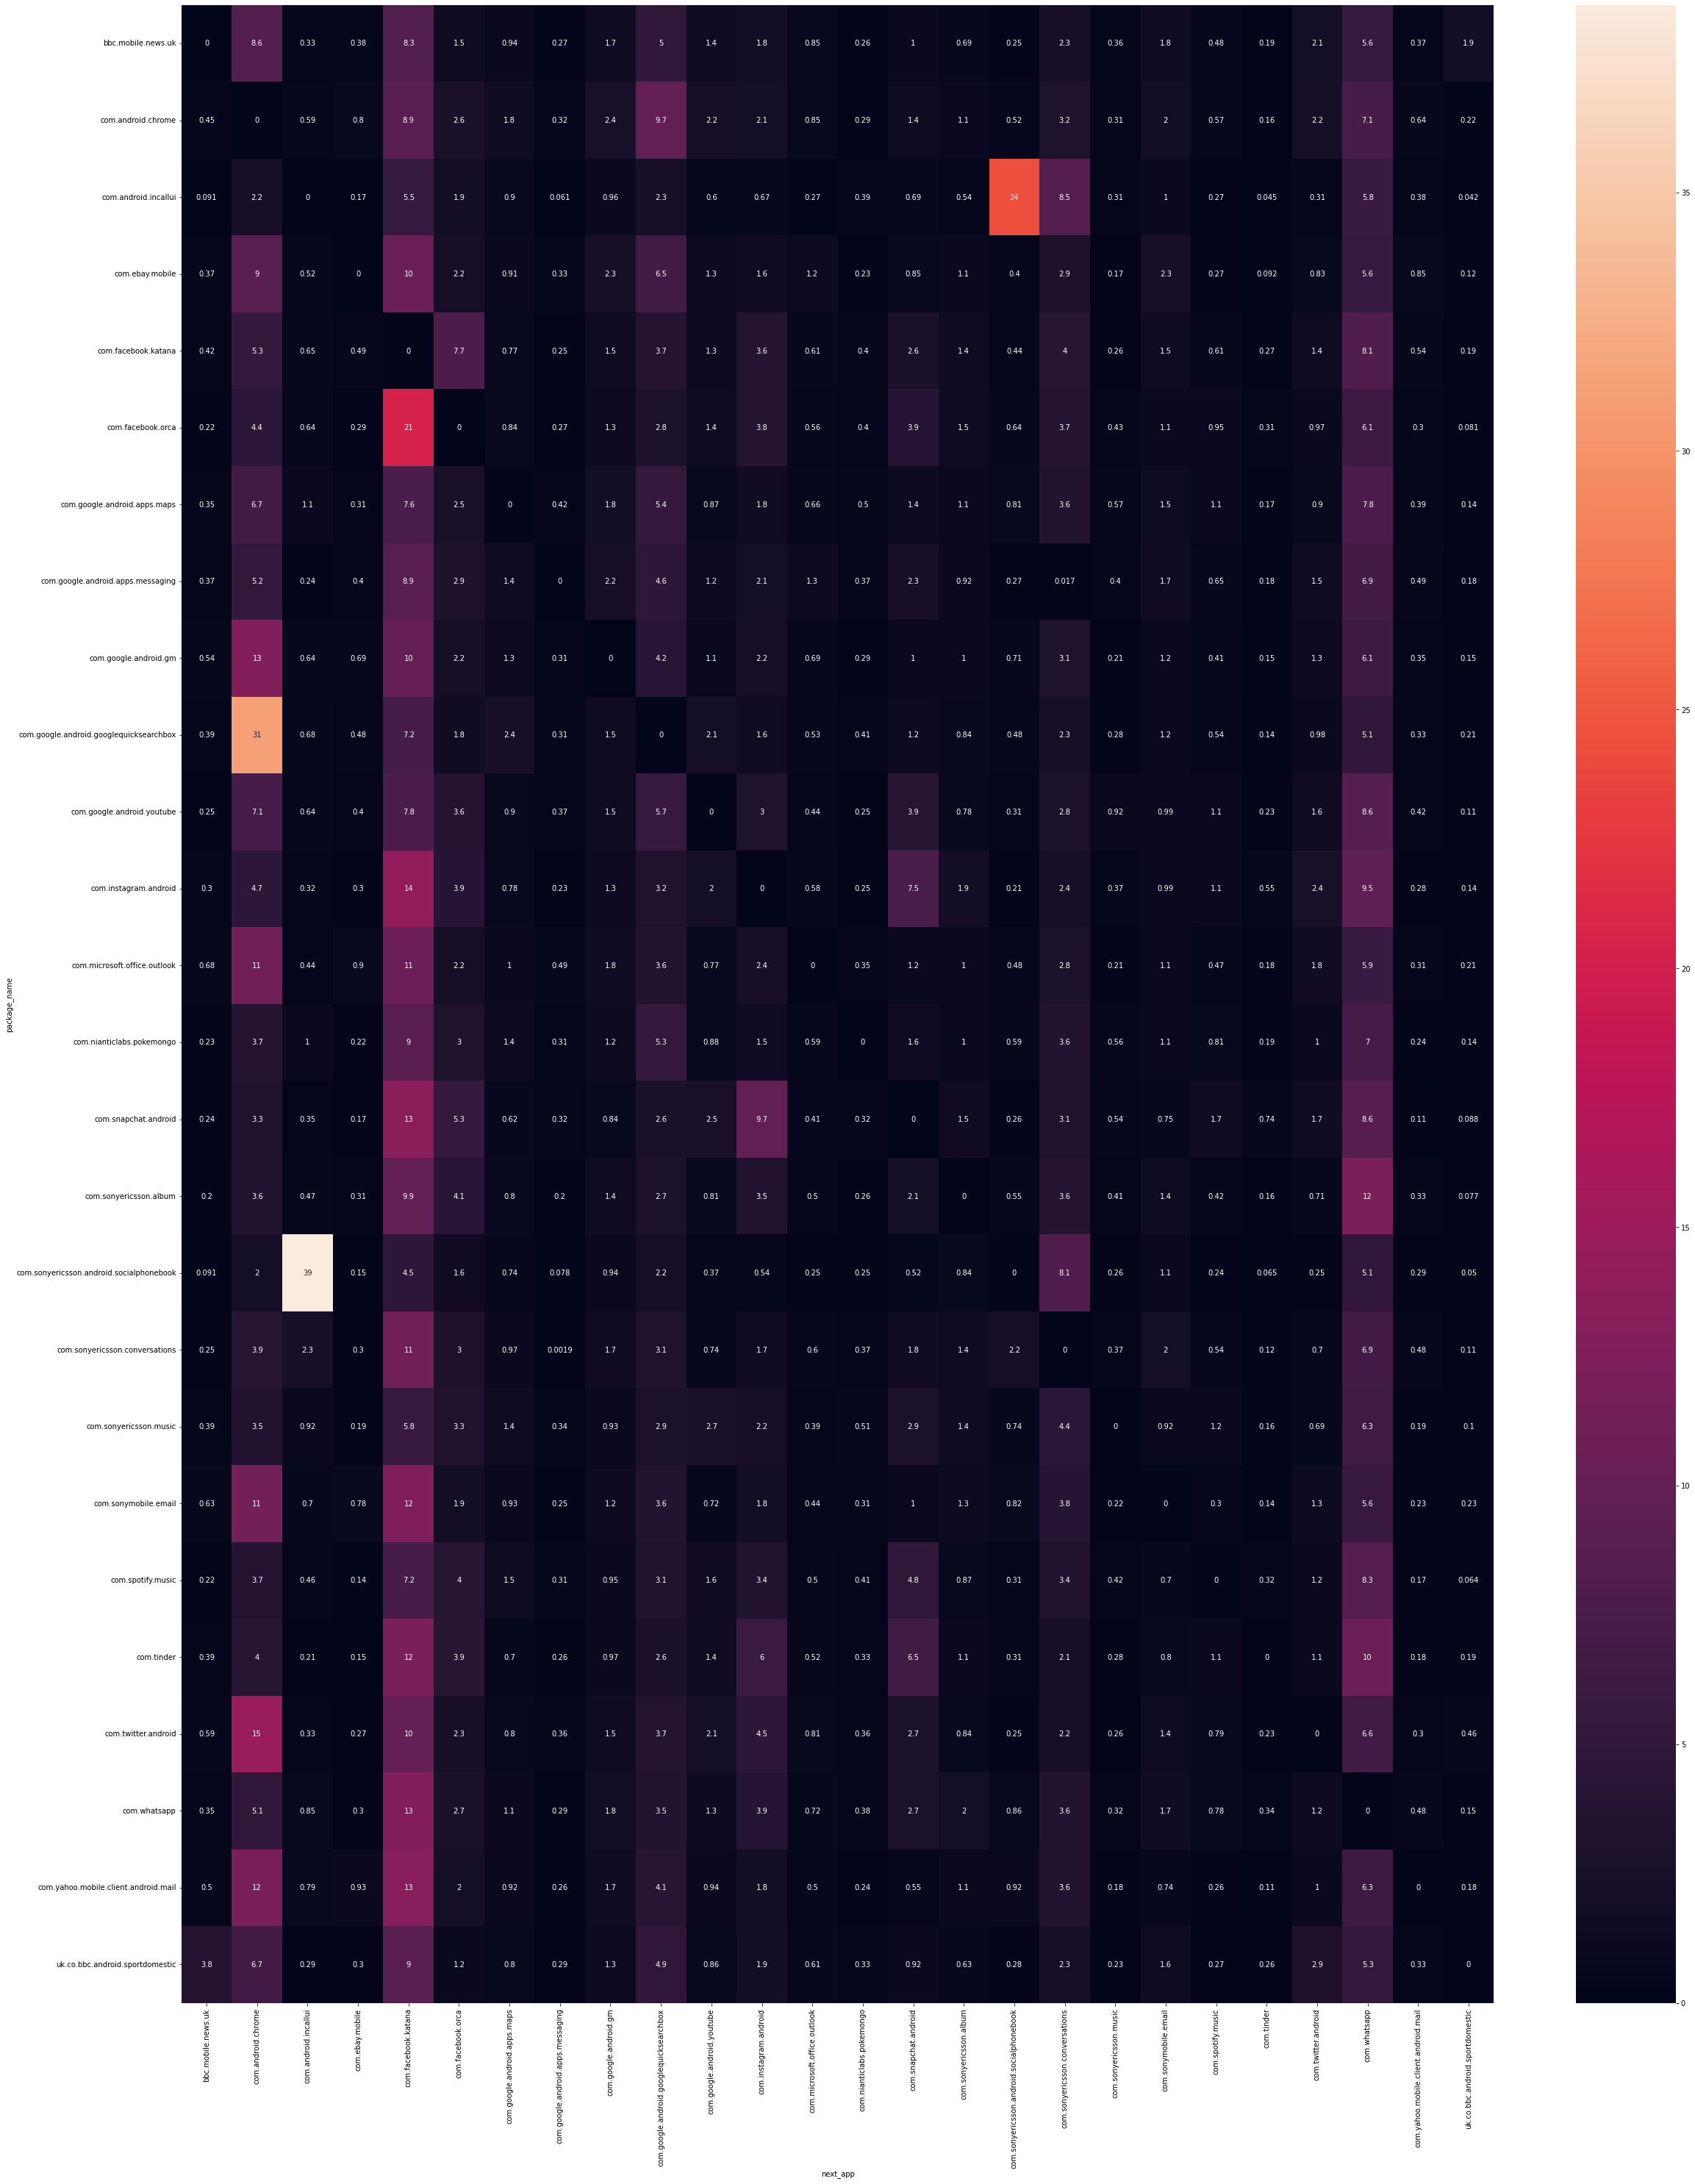

In [61]:
fig, ax = plt.subplots(figsize=(40,50))  
ax = sns.heatmap(Transaction_matrix, annot=True)
#ax.set_title('Transaction matrix of 23 frequent apps from 80% apps coverage in whole dataset ')

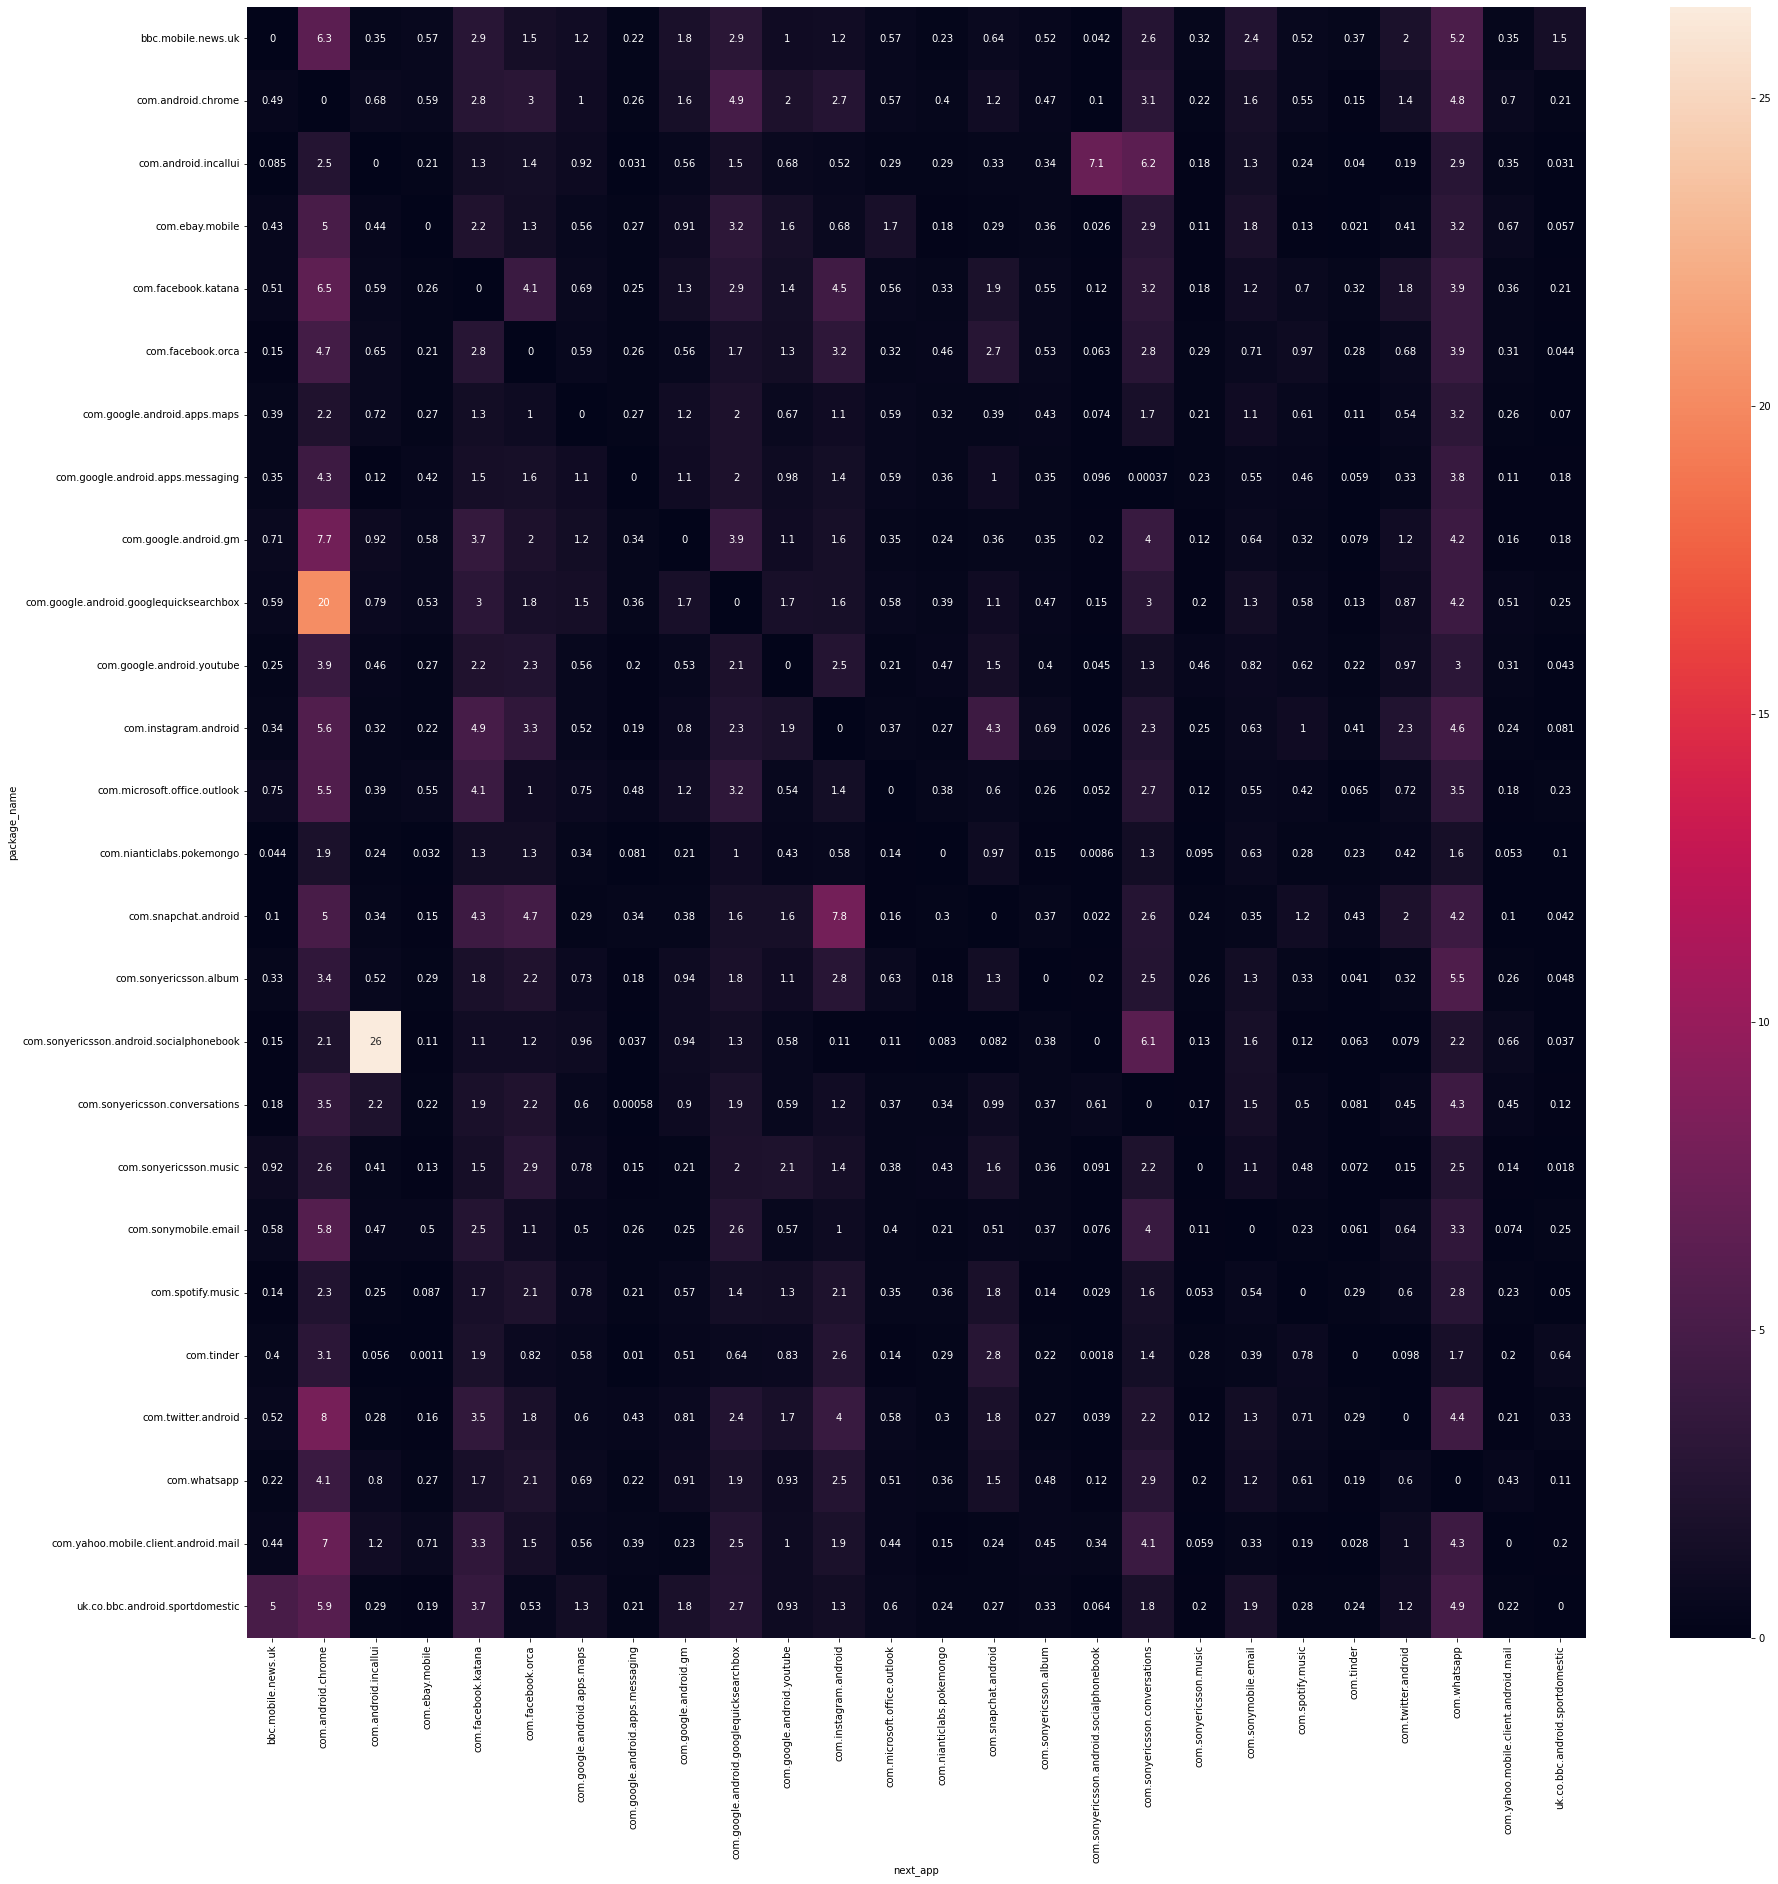

In [62]:
fig1, ax1 = plt.subplots(figsize=(30,30))  
ax1 = sns.heatmap(Transaction_matrix_merge, annot=True)
#ax.set_title('Transaction matrix of 23 frequent apps from 80% apps coverage in 80 coverage dataset  ')